# CartPole Implementation - REINFORCE Algo

In [14]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from time import sleep

## Policy Network

This NN represents the agent's policy in the REINFORCE algo. 

The network maps action states to action probabilities, which will define the agent's behavior stategy. For CartPole, it takes a 4D state as input and outputs 2 possible actions (right or left).

Architecture:

- Input: 4 neurons (state space dimensions)
- Hidden Layer: 128 neurons, ReLU activation
- Output: 2 neurons (left or right), Softmax activation

State Space Input:

1. Cart Positionn: -2.4 to +2.4
2. Cart Velocity: -Inf to +Inf
3. Pole Angle: -41.8 degrees to +41.8 degrees
4. Pole Angular Velocity: -Inf to +Inf

In [15]:
# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=2):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.network(x)

## REINFORCE Agent class

Implementation of the REINFORCE algorithm (Monte Carlo Gradient) for CartPole.

The REINFORCE algo is a policy gradient method that learns by:

1. Collecting complete episodes using current policy
2. Computing discounted returns for each timestamp
3. Update policy network to increase probabilities that lead to higher returns

Attributes:

    env (gym.Env): Training environment instance
    eval_env (gym.Env): Seperate environment for evaluation, with rendering enabled
    gamma: discount factor for future rewards (0 to 1)
    policy (PolicyNetwork): NN defined earlier
    optimizer: optimizer for policy network updates
    states (list): stores states in current episode
    action_probs (list): stores action log probabilities for current episode.

Methods:

    select_action(self, state): Selects action using current policy.
    calculate_returns(self): Calculates discounted returns fopr each timestep in episode
    update_policy(self): Updates polocy network using REINFORCE algo.
    train(self, num_episodes): Trains the agent using the REINFORCE algo.
    evaluate(self)

In [ ]:
# REINFORCE Agent Definition
class REINFORCEAgent:
    def __init__(self, env_name="CartPole-v1", learning_rate=0.01, gamma=0.99):
        # Setting random seeds for reproducibility
        torch.manual_seed(42)
        np.random.seed(42)

        # Set device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Device: {self.device}")
        
        # Initialize environments
        self.env = gym.make(env_name)
        self.eval_env = gym.make(env_name, render_mode="human")

        self.gamma = gamma
        self.policy = PolicyNetwork().to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)

        # Episode logging
        self.states = []
        self.action_probs = []
        self.rewards = []

    def select_action(self, state):
        '''
        Method to select action based on the current state. 
        This method passes state into policy network to get action probabilities.
        It then samples an action from the distribution and returns it.
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        probs = self.policy(state)
        distribution = Categorical(probs)
        action = distribution.sample()
        self.action_probs.append(distribution.log_prob(action))
        
        return action.item()
    
    def calculate_returns(self):
        '''
        Method to calculate discounted returns for each timestamp in an episode.
        Returns are normalized using mean and std deviation. 
        '''
        returns = []
        R = 0
        
        # Calculate returns backwards
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        
        # Convert to tensor and normalize
        returns = torch.FloatTensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        return returns   

    def update_policy(self):
        ''' 
        Updates policy network using REINFORCE algorithm.
        ''' 
        returns = self.calculate_returns()
        
        # Calculate policy gradient loss
        policy_loss = []
        for log_prob, R in zip(self.action_probs, returns):
            policy_loss.append(-log_prob * R)
        
        # Sum up all the losses
        policy_loss = torch.cat(policy_loss).sum()
        
        # Update policy network
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # Clear episode storage
        self.states = []
        self.action_probs = []
        self.rewards = []

    def train(self, num_episodes=1000):
        ''' 
        Training loop for the agent.

        For each episode:
            - Reset environment
            - Collection experience until episode ends
            - Update policy network
            - Track and report progress
        
        Returns the rewards obtained in each episode.
        '''
        episode_rewards = []

        for episode in range(num_episodes):
            # Reset environment
            try:
                state, _ = self.env.reset()
            except ValueError:
                state = self.env.reset()
            
            episode_reward = 0
            done = False

            # Episode collection loop
            while not done:
                action = self.select_action(state)

                try:
                    state, reward, terminated, truncated, _ = self.env.step(action)
                    done = terminated or truncated # End episode if terminated or truncated
                except ValueError:
                    state, reward, done, _ = self.env.step(action)
                
                self.rewards.append(reward)
                episode_reward += reward

            # Update policy after each episode
            self.update_policy()
            episode_rewards.append(episode_reward)

            # Report progress every 100 episodes
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(f'Episode {episode + 1}\tAverage Reward: {avg_reward:.2f}')
        
        return episode_rewards
    
    def evaluate(self, num_episodes=5, delay=0.02):
        ''' 
        Evaluation loop for the agent.

        For each episode:
            - Reset environment
            - Select action based on policy
            - Track and report progress
        
        Returns the rewards obtained in each episode.
        '''
        print("\nStarting evaluation...")
        evaluation_rewards = []
        max_possible_reward = 500  # Maximum possible reward for CartPole-v1
        perfect_episodes = 0

        for episode in range(num_episodes):
            try:
                state, _ = self.eval_env.reset()
            except ValueError:
                state = self.eval_env.reset()

            episode_reward = 0
            done = False
            steps = 0

            while not done:
                # Select action (using the maximum probability action for evaluation)
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                    probs = self.policy(state_tensor)
                    action = torch.argmax(probs).item()

                try:
                    state, reward, terminated, truncated, _ = self.eval_env.step(action)
                    done = terminated or truncated
                except ValueError:
                    state, reward, done, _ = self.eval_env.step(action)

                episode_reward += reward
                steps += 1

                sleep(delay)  # Add delay for better visualization

            # Check if this was a perfect episode
            if episode_reward >= max_possible_reward:
                perfect_episodes += 1

            print(f"Episode {episode + 1}: Reward = {episode_reward}, Steps = {steps}")
            evaluation_rewards.append(episode_reward)

        avg_reward = np.mean(evaluation_rewards)
        std_reward = np.std(evaluation_rewards)
        
        print(f"\nEvaluation Results over {num_episodes} episodes:")
        print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
        print(f"Max Reward: {max(evaluation_rewards)}")
        print(f"Min Reward: {min(evaluation_rewards)}")
        print(f"Perfect Episodes: {perfect_episodes}/{num_episodes} ({(perfect_episodes/num_episodes)*100:.1f}%)")
        print(f"Performance: {(avg_reward/max_possible_reward)*100:.1f}% of maximum possible reward")
        
        return evaluation_rewards 
    
    def evaluate_and_save_gif(self, num_episodes=1, filename="cartpole_evaluation.gif", fps=30):
        """
        Evaluate the agent and save the rendering as a GIF.
        
        Args:
            num_episodes (int): Number of episodes to record
            filename (str): Output filename for the GIF
            fps (int): Frames per second for the output GIF
        """
        print("\nRecording evaluation...")
        frames = []
        
        # Create environment with RGB array rendering
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        
        for episode in range(num_episodes):
            try:
                state, _ = env.reset()
            except ValueError:
                state = env.reset()
            
            episode_reward = 0
            done = False
            steps = 0
            
            while not done:
                # Render and capture frame
                frame = env.render()
                frames.append(Image.fromarray(frame))
                
                # Select action using trained policy
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                    probs = self.policy(state_tensor)
                    action = torch.argmax(probs).item()
                
                try:
                    state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated
                except ValueError:
                    state, reward, done, _ = env.step(action)
                
                episode_reward += reward
                steps += 1
            
            print(f"Episode {episode + 1}: Reward = {episode_reward}, Steps = {steps}")
        
        env.close()
        
        # Save frames as GIF
        if frames:
            print(f"Saving GIF to {filename}")
            frames[0].save(
                filename,
                save_all=True,
                append_images=frames[1:],
                duration=1000/fps,  # Duration between frames in milliseconds
                loop=0
            )
            print("GIF saved successfully!")
        
        return episode_reward

    def save_model(self, path='cartpole_agent.pth'):
        torch.save(self.policy.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path='cartpole_agent.pth'):
        self.policy.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")

    def plot_results(self, rewards):
        ''' 
        Method to plot the rewards over time.
        '''
        # Calculate rolling average
        rolling_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
        
        plt.figure(figsize=(10, 5))
        plt.plot(rolling_avg)
        plt.title('Average Reward over Time')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward (100 episodes)')
        plt.show()


Device: cuda
Training agent...
Episode 100	Average Reward: 11.12
Episode 200	Average Reward: 82.69
Episode 300	Average Reward: 49.50
Episode 400	Average Reward: 102.56
Episode 500	Average Reward: 78.48
Episode 600	Average Reward: 126.94
Episode 700	Average Reward: 330.47
Episode 800	Average Reward: 489.59
Episode 900	Average Reward: 488.24
Episode 1000	Average Reward: 499.34
Episode 1100	Average Reward: 433.42
Episode 1200	Average Reward: 493.19
Episode 1300	Average Reward: 499.33
Episode 1400	Average Reward: 492.38
Episode 1500	Average Reward: 475.64


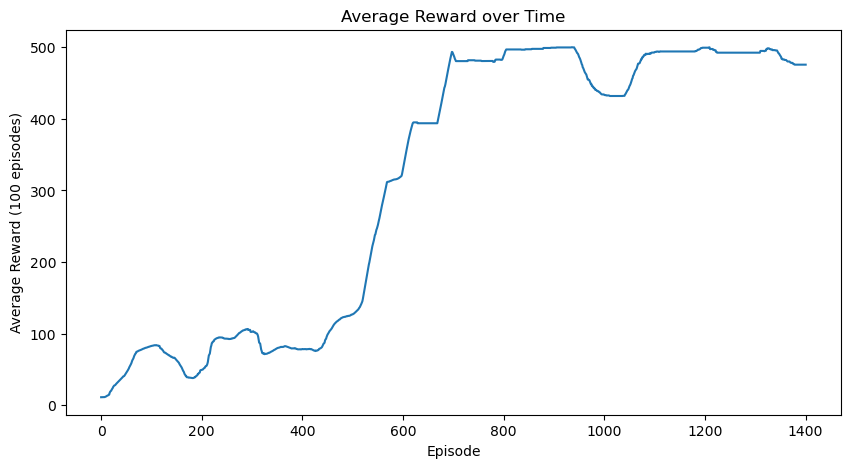

Model saved to cartpole_agent.pth


In [20]:
# Create and train the agent
agent = REINFORCEAgent()
print("Training agent...")
rewards = agent.train(num_episodes=1500)
agent.plot_results(rewards)

# Save the trained model
agent.save_model()

In [ ]:
agent = REINFORCEAgent()

# # Load the trained model
agent.load_model()

# Evaluate the agent with rendering
print("\nEvaluating agent...")
agent.evaluate(num_episodes=5, delay=0.01)


Evaluating agent...

Starting evaluation...
Episode 1: Reward = 500.0, Steps = 500
Episode 2: Reward = 500.0, Steps = 500
Episode 3: Reward = 500.0, Steps = 500
Episode 4: Reward = 500.0, Steps = 500
Episode 5: Reward = 500.0, Steps = 500

Evaluation Results over 5 episodes:
Average Reward: 500.00 ± 0.00
Max Reward: 500.0
Min Reward: 500.0
Perfect Episodes: 5/5 (100.0%)
Performance: 100.0% of maximum possible reward


[500.0, 500.0, 500.0, 500.0, 500.0]